# Stage 2 Myna: Pretrained Audio Encoder Embedding Extraction

이 노트북은 **Myna (pretrained self-supervised 오디오 인코더)**를 사용하여 곡별 오디오 임베딩을 추출합니다.

## 목적
- 기존 CNN 기반 Stage2와 동일한 **5만 곡**에 대해 Myna 임베딩 추출
- **샤드 npz 파일 기반**으로 멜 스펙트로그램 로딩 (개별 npy 대신)
- 결과를 `audio_embeddings_myna_stage2.npz`로 저장
- **CNN vs Myna 이웃 비교** 분석 포함

## Myna 모델 정보
- **Hugging Face**: `oriyonay/myna-vertical`
- **아키텍처**: Vision Transformer (ViT) on mel-spectrograms
- **입력**: `(128, 96)` 형태 (멜빈 128개, 시간축 96)
- **출력**: 384차원 임베딩
- **특징**: Token masking 기반 contrastive learning, pitch sensitivity 보존

## 데이터 소스
- **샤드 파일**: `mel_shards/mel_shard_XXX.npz` (각 파일: song_ids, mel 배열 포함)
- 개별 npy 파일이 아닌 **샤드 단위 배치 처리**로 효율적인 임베딩 추출

---
**2025-12-XX: Stage2 Myna 전용 임베딩 생성 + CNN vs Myna 이웃 비교 노트북**  
CNN 모델 학습/임베딩 생성 코드는 제거되었고, 외부에서 생성된 CNN 임베딩만 비교용으로 사용함.

In [6]:
# GPU 확인
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Dec  9 21:40:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0             15W /   60W |     630MiB /   4096MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# [Cell 1] 환경 설정 & 기본 상수 정의

import os
import sys
import json
import random
import logging
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def set_seed(seed: int = 42):
    """재현성을 위한 난수 시드 고정"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ============================================================
# 샤드 기반 경로 설정 (recommend_model 폴더 기준)
# ============================================================

# 샤드 루트 경로
SHARD_ROOT = Path("../mel_shards")  # recommend_model 폴더 기준

# 샤드 파일 패턴
SHARD_PATTERN = "mel_shard_*.npz"

# Myna 임베딩 출력 경로
MYNA_EMB_OUTPUT = Path("../models/audio_embeddings_myna_stage2.npz")
MYNA_EMB_OUTPUT.parent.mkdir(parents=True, exist_ok=True)

# CNN 임베딩 경로 (비교용 로드 전용)
CNN_EMB_PATH = Path("../models/audio_embeddings_stage2.npz")

# 곡 메타데이터 경로
SONG_META_PATH = Path("../melon-dataset-excepttar/song_meta.json")

# ============================================================
# 오디오 처리 관련 상수
# ============================================================

# 샤드 내 멜 스펙 형태
SHARD_FIXED_T = 1536  # 샤드에 저장된 고정 길이
ORIGINAL_N_MELS = 48

# Myna 입력 스펙
MYNA_N_MELS = 128
MYNA_N_FRAMES = 96

# 하이퍼파라미터
BATCH_SIZE = 64
RANDOM_SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
set_seed(RANDOM_SEED)

# 경로 확인
print(f"\n📁 경로 확인:")
print(f"  - SHARD_ROOT: {SHARD_ROOT} (exists: {SHARD_ROOT.exists()})")
print(f"  - CNN_EMB_PATH: {CNN_EMB_PATH} (exists: {CNN_EMB_PATH.exists()})")
print(f"  - MYNA_EMB_OUTPUT: {MYNA_EMB_OUTPUT}")
print(f"  - SONG_META_PATH: {SONG_META_PATH} (exists: {SONG_META_PATH.exists()})")

INFO:__main__:Using device: cpu



📁 경로 확인:
  - SHARD_ROOT: C:\Users\ASUS\music_recommend\work\mel_shards (exists: True)
  - CNN_EMB_PATH: C:\Users\ASUS\music_recommend\work\models\audio_embeddings_stage2.npz (exists: True)
  - MYNA_EMB_OUTPUT: C:\Users\ASUS\music_recommend\work\models\audio_embeddings_myna_stage2.npz
  - SONG_META_PATH: C:\Users\ASUS\music_recommend\work\melon-dataset-excepttar\song_meta.json (exists: True)


In [2]:
# [Cell 2] mel_shards 기반 멜 로딩 유틸 + 배치 전처리

def list_shard_paths() -> List[Path]:
    """
    SHARD_ROOT 아래의 mel_shard_*.npz 파일들을 shard_idx 순서대로 반환
    """
    shard_paths = sorted(SHARD_ROOT.glob(SHARD_PATTERN))
    if not shard_paths:
        raise RuntimeError(f"샤드 파일을 찾지 못함: {SHARD_ROOT / SHARD_PATTERN}")
    print(f"[INFO] 발견된 샤드 수: {len(shard_paths)}")
    return shard_paths


def load_shard(shard_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """
    샤드 하나를 로드해서 (song_ids, mel) 반환
    
    Returns:
        song_ids: (N,) 곡 ID 배열
        mel: (N, n_mels, FIXED_T) 멜 스펙트로그램 배열
    """
    data = np.load(shard_path)
    song_ids = data["song_ids"]  # (N,)
    mel = data["mel"]            # (N, n_mels, FIXED_T)
    return song_ids, mel


def count_total_songs(shard_paths: List[Path]) -> int:
    """
    전체 샤드의 총 곡 수를 효율적으로 계산합니다.
    mel 배열 전체를 로드하지 않고 song_ids.shape[0]만 읽습니다.
    """ 
    total = 0
    for shard_path in shard_paths:
        with np.load(shard_path, mmap_mode="r") as data:
            total += data["song_ids"].shape[0]
    return total


def preprocess_mel_batch_for_myna(
    mel_batch: np.ndarray,
    target_n_mels: int = MYNA_N_MELS,
    target_n_frames: int = MYNA_N_FRAMES,
    device: torch.device = None,
    center_crop: bool = True,
) -> torch.Tensor:
    """
    배치 단위로 멜 스펙트로그램을 Myna 입력 형태로 변환합니다 (torch 기반).
    
    Args:
        mel_batch: (B, n_mels, T) 형태의 배치
        target_n_mels: 목표 주파수 빈 수 (기본 128)
        target_n_frames: 목표 시간 프레임 수 (기본 96)
        device: torch device (None이면 자동 선택)
        center_crop: True면 center crop, False면 처음부터 crop
        
    Returns:
        (B, 1, target_n_mels, target_n_frames) 형태의 torch.Tensor
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    assert mel_batch.ndim == 3, f"mel_batch ndim must be 3, got {mel_batch.ndim}"
    B, n_mels, T = mel_batch.shape
    
    # 1) 시간 축 길이를 target_n_frames로 맞추기 (center crop + pad)
    if T > target_n_frames:
        if center_crop:
            start = (T - target_n_frames) // 2  # center crop (추론용, 재현성 보장)
        else:
            start = 0
        mel_batch = mel_batch[:, :, start:start + target_n_frames]
        T = target_n_frames
    elif T < target_n_frames:
        pad_T = target_n_frames - T
        mel_batch = np.pad(
            mel_batch,
            pad_width=((0, 0), (0, 0), (0, pad_T)),
            mode="constant",
        )
        T = target_n_frames
    
    # 2) torch 텐서로 변환: (B, 1, n_mels, T) #
    # unsqueeze(1) : CNN은 (채널, 높이, 너비)를 원하니까 채널 = 1 인 흑백 이미지처럼 보이게 1짜리 차원을 중간에 하나 끼워 넣는 것”
    mel_tensor = torch.from_numpy(mel_batch).unsqueeze(1).float().to(device)
    
    # 3) 주파수/시간 방향으로 interpolate (필요시)
    if (n_mels != target_n_mels) or (T != target_n_frames):
        mel_tensor = F.interpolate(
            mel_tensor,
            size=(target_n_mels, target_n_frames),
            mode="bilinear",
            align_corners=False,
        )
    
    return mel_tensor


# 샤드 목록 확인
shard_paths = list_shard_paths()

# 샘플 샤드 로드 테스트
sample_shard_path = shard_paths[0]
sample_song_ids, sample_mel = load_shard(sample_shard_path)
print(f"\n📦 샘플 샤드: {sample_shard_path.name}")
print(f"   - song_ids shape: {sample_song_ids.shape}")
print(f"   - mel shape: {sample_mel.shape}")

# Myna 배치 전처리 테스트
test_batch = sample_mel[:4]  # (4, 48, 1536)
test_batch_myna = preprocess_mel_batch_for_myna(test_batch, device=device)
print(f"\n✅ Myna 배치 전처리 테스트:")
print(f"   - 원본: {test_batch.shape}")
print(f"   - Myna 입력: {test_batch_myna.shape}")

[INFO] 발견된 샤드 수: 100

📦 샘플 샤드: mel_shard_000.npz
   - song_ids shape: (500,)
   - mel shape: (500, 48, 1536)

✅ Myna 배치 전처리 테스트:
   - 원본: (4, 48, 1536)
   - Myna 입력: torch.Size([4, 1, 128, 96])


In [3]:
# [Cell 3] 전체 곡 수 확인 (mmap_mode로 효율적 계산)

total_songs = count_total_songs(shard_paths)

print(f"📊 전체 샤드 통계:")
print(f"   - 샤드 수: {len(shard_paths)}개")
print(f"   - 총 곡 수: {total_songs:,}곡")
print(f"   - 예상 Myna 임베딩 shape: ({total_songs}, embed_dim)")

📊 전체 샤드 통계:
   - 샤드 수: 100개
   - 총 곡 수: 50,000곡
   - 예상 Myna 임베딩 shape: (50000, embed_dim)


In [4]:
# [Cell 4] Myna 모델 로드

# Myna 설치 (필요시)
# !pip install -q transformers

from transformers import AutoModel

def load_myna_encoder(model_name: str = "oriyonay/myna-vertical"):
    """
    Myna pretrained 오디오 인코더를 로드합니다.
    
    Myna는 ViT 기반 self-supervised 모델로,
    멜 스펙트로그램 (128, 96)을 입력받아 384차원 임베딩을 출력합니다.
    
    Raises:
        RuntimeError: 모델 로드 실패 시
    """
    try:
        model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        logger.info(f"✅ Myna 모델 로드 성공: {model_name}")
    except Exception as e:
        logger.error(f"❌ Myna 모델 로드 실패: {model_name}")
        logger.error(f"   원인: {e}")
        logger.error("   해결 방법:")
        logger.error("   1. 인터넷 연결 확인")
        logger.error("   2. pip install transformers 확인")
        logger.error("   3. HuggingFace 모델 페이지 확인: https://huggingface.co/oriyonay/myna-vertical")
        raise RuntimeError(f"Myna 모델 로드 실패: {e}") from e
    
    model = model.to(device)
    model.eval()
    
    return model

# Myna 모델 로드
myna_model = load_myna_encoder()

# 모델 정보 출력
total_params = sum(p.numel() for p in myna_model.parameters())
print(f"\n📊 Myna 모델 정보:")
print(f"   - 총 파라미터 수: {total_params:,}")
print(f"   - Device: {device}")

INFO:__main__:✅ Myna 모델 로드 성공: oriyonay/myna-vertical



📊 Myna 모델 정보:
   - 총 파라미터 수: 21,375,872
   - Device: cpu


📊 batch_mel 기본 정보
  shape: (4, 48, 1536)
  dtype: float32
  min: -89.2966
  max: 23.4868
  mean: -18.5922
  std: 14.9410

📊 개별 곡별 통계
  곡 0 (song_id=3): min=-65.58, max=21.95, mean=-16.43
  곡 1 (song_id=9): min=-89.30, max=15.97, mean=-24.50
  곡 2 (song_id=40): min=-53.32, max=23.49, mean=-10.91
  곡 3 (song_id=54): min=-77.53, max=18.16, mean=-22.53

📊 실제 데이터 일부 (첫 번째 곡, 처음 5개 멜빈, 처음 10프레임)
[[  4.6776476    9.716665     9.821891     9.678806     9.896402
    9.844665     9.675523     8.014803     4.537847     0.54064834]
 [ -3.7941413    2.0429945    2.402832     2.5889454    3.288424
    2.009318     1.1048012   -1.3860619   -3.581722    -1.9244831 ]
 [ -8.39182     -9.498139     2.8067358    0.51007307   0.5595147
    1.8451265    3.1275318    5.560638     4.1395936    5.8486204 ]
 [-13.155329   -11.785223     1.3388427    8.348784     7.0913043
    8.072303    10.535175    10.400372     0.11648502   0.98382723]
 [ -9.738757   -11.0542     -11.608449     0.55058616  -1.1830609
   -1.9

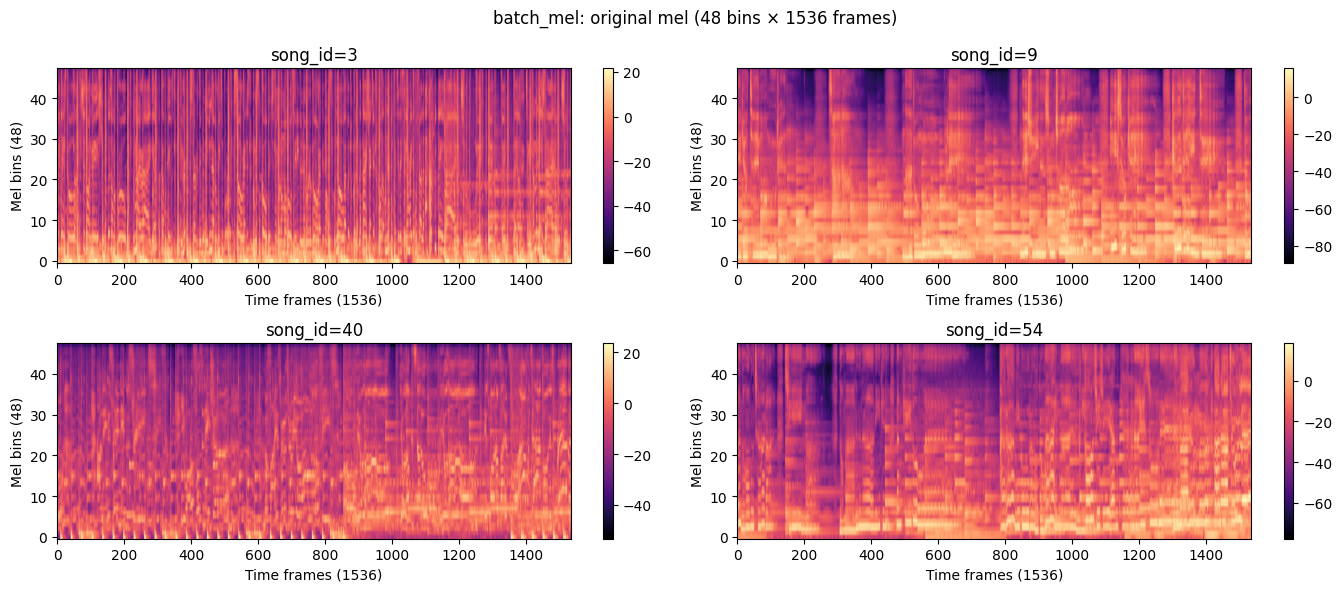

In [11]:
# [디버깅] batch_mel 데이터 구경하기

import matplotlib.pyplot as plt

# 첫 번째 샤드에서 샘플 배치 가져오기
sample_song_ids, sample_mel = load_shard(shard_paths[0])
batch_mel = sample_mel[:4]  # 4곡만

print("=" * 60)
print("📊 batch_mel 기본 정보")
print("=" * 60)
print(f"  shape: {batch_mel.shape}")  # (B, n_mels, T) = (4, 48, 1536)
print(f"  dtype: {batch_mel.dtype}")
print(f"  min: {batch_mel.min():.4f}")
print(f"  max: {batch_mel.max():.4f}")
print(f"  mean: {batch_mel.mean():.4f}")
print(f"  std: {batch_mel.std():.4f}")

print("\n" + "=" * 60)
print("📊 개별 곡별 통계")
print("=" * 60)
for i in range(len(batch_mel)):
    mel = batch_mel[i]
    print(f"  곡 {i} (song_id={sample_song_ids[i]}): "
          f"min={mel.min():.2f}, max={mel.max():.2f}, mean={mel.mean():.2f}")

print("\n" + "=" * 60)
print("📊 실제 데이터 일부 (첫 번째 곡, 처음 5개 멜빈, 처음 10프레임)")
print("=" * 60)
print(batch_mel[0, :5, :10])

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(batch_mel[i], aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"song_id={sample_song_ids[i]}")
    ax.set_xlabel("Time frames (1536)")
    ax.set_ylabel("Mel bins (48)")
    plt.colorbar(im, ax=ax)

plt.suptitle("batch_mel: original mel (48 bins × 1536 frames)", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# [Cell 5] Myna 임베딩 추출 (샤드 기반, pre-allocation + 개선된 예외 처리)

model = myna_model.to(device)
model.eval()

# Pre-allocation: 총 곡 수를 미리 알고 있으므로 배열을 미리 할당
all_song_ids = np.empty(total_songs, dtype=np.int64)
all_embeddings = None  # embed_dim은 첫 배치에서 결정
current_idx = 0

# 실패한 배치 정보를 누적
failed_ranges = []

print(f"🚀 Myna 임베딩 추출 시작 (샤드 기반, pre-allocation)")
print(f"   - 샤드 수: {len(shard_paths)}개")
print(f"   - 총 곡 수: {total_songs:,}곡")
print(f"   - BATCH_SIZE: {BATCH_SIZE}")
print(f"   - Device: {device}")
print("=" * 60)

for shard_idx, shard_path in enumerate(shard_paths):
    # 샤드 로드
    shard_song_ids, shard_mel = load_shard(shard_path)  # (N,), (N, n_mels, FIXED_T)
    N, n_mels, T = shard_mel.shape
    
    # 샤드 내에서 배치 단위로 나눠서 Myna 통과
    for start in tqdm(
        range(0, N, BATCH_SIZE), 
        desc=f"Shard {shard_idx+1}/{len(shard_paths)}: {shard_path.name}", 
        leave=False
    ):
        end = min(start + BATCH_SIZE, N) # 배치 끝 인덱스 계산: 샤드의 곡 수를 초과하지 않도록 제한
        batch_mel = shard_mel[start:end]  # (B, n_mels, FIXED_T)
        
        try:
            # 배치 전처리: (B, n_mels, T) -> (B, 1, target_n_mels, target_n_frames)
            batch_tensor = preprocess_mel_batch_for_myna(
                batch_mel,
                target_n_mels=MYNA_N_MELS,
                target_n_frames=MYNA_N_FRAMES,
                device=device,
                center_crop=True,  # 추론이므로 재현성을 위해 center crop
            )
            
            with torch.no_grad(): # 기울기 추적 중지    
                batch_emb = model(batch_tensor)
                
                # 결과 형태 처리 (모델에 따라 다를 수 있음)
                if isinstance(batch_emb, tuple):
                    batch_emb = batch_emb[0]
                if len(batch_emb.shape) > 2:
                    batch_emb = batch_emb.mean(dim=1)  # 시퀀스 평균
                
                # L2 정규화는 검색 단계에서 수행하므로 여기서는 raw embedding 저장
                batch_emb_np = batch_emb.cpu().numpy().astype(np.float32)
            
            B, D = batch_emb_np.shape
            
            # 첫 배치에서 embed_dim 결정 후 배열 할당
            if all_embeddings is None:
                all_embeddings = np.empty((total_songs, D), dtype=np.float32)
                print(f"   - Embedding dim: {D}")
            
            # Pre-allocated 배열에 직접 저장
            all_embeddings[current_idx:current_idx+B] = batch_emb_np
            all_song_ids[current_idx:current_idx+B] = shard_song_ids[start:end]
            current_idx += B
                
        except Exception as e:
            logger.exception(
                f"[ERROR] 배치 처리 실패: shard={shard_path.name}, "
                f"start={start}, end={end}, err={e}"
            )
            failed_ranges.append({
                "shard": shard_path.name,
                "start": int(start),
                "end": int(end),
                "song_ids": shard_song_ids[start:end].tolist(),
                "error": str(e),
            })
            continue
    
    print(f"  ✅ {shard_path.name} 완료 ({N}곡)")

# 검증
print("\n" + "=" * 60)
if current_idx == total_songs:
    print(f"✅ Myna 임베딩 추출 완료!")
else:
    print(f"⚠️ 일부 곡 누락: 처리된 곡 {current_idx:,}, 예상 {total_songs:,}")
    # 실제 처리된 곡 수만큼 배열 자르기
    all_song_ids = all_song_ids[:current_idx]
    all_embeddings = all_embeddings[:current_idx]

print(f"   - song_ids shape: {all_song_ids.shape}")
print(f"   - embeddings shape: {all_embeddings.shape}")

In [ ]:
# [Cell 6] Myna 임베딩 저장 + 실패 배치 로깅

# 저장
np.savez_compressed(
    str(MYNA_EMB_OUTPUT),
    song_ids=all_song_ids,
    embeddings=all_embeddings
)

logger.info(f"✅ Myna 임베딩 저장 완료: {MYNA_EMB_OUTPUT}")

# 검증
verify_data = np.load(str(MYNA_EMB_OUTPUT))
print(f"\n📊 저장 검증:")
print(f"   - song_ids: {verify_data['song_ids'].shape}")
print(f"   - embeddings: {verify_data['embeddings'].shape}")
print(f"   - 파일 크기: {MYNA_EMB_OUTPUT.stat().st_size / 1024 / 1024:.2f} MB")

# 실패 배치 정보 출력/저장
if failed_ranges:
    print(f"\n⚠️ [WARN] 처리 실패 배치 수: {len(failed_ranges)}")
    
    failed_path = MYNA_EMB_OUTPUT.with_name("myna_failed_batches.json")
    with open(failed_path, "w", encoding="utf-8") as f:
        json.dump(failed_ranges, f, ensure_ascii=False, indent=2)
    
    print(f"   - 실패 배치 정보 저장됨: {failed_path}")
    
    # 실패한 곡 ID 총 개수
    failed_song_count = sum(len(r["song_ids"]) for r in failed_ranges)
    print(f"   - 실패한 곡 수: {failed_song_count:,}곡")
else:
    print("\n✅ [INFO] 모든 배치가 예외 없이 처리됨.")

---

## CNN vs Myna 이웃 비교

이 섹션에서는 동일한 seed 곡에 대해 **CNN 임베딩**과 **Myna 임베딩**이 각각 어떤 이웃을 찾는지 비교합니다.

- CNN 임베딩: `audio_embeddings_stage2.npz` (기존 생성된 파일 로드)
- Myna 임베딩: `audio_embeddings_myna_stage2.npz` (이 노트북에서 생성)

In [7]:
# [Cell 7] CNN vs Myna 비교용 임베딩 로드 함수 + song_id 인덱스 생성

def load_audio_embeddings(npz_path) -> Tuple[np.ndarray, np.ndarray]:
    """
    오디오 임베딩 npz 파일을 로드합니다.
    
    Returns:
        song_ids: (N,) 곡 ID 배열
        embeddings: (N, D) 임베딩 배열
    """
    npz_path = Path(npz_path)
    if not npz_path.exists():
        raise FileNotFoundError(f"Embedding file not found: {npz_path}")
    
    data = np.load(str(npz_path))
    
    # 두 가지 저장 형식 지원
    if 'song_ids' in data.files and 'embeddings' in data.files:
        # 새 형식: song_ids, embeddings 배열
        song_ids = data['song_ids']
        embeddings = data['embeddings']
    else:
        # 구 형식: {song_id: embedding} 딕셔너리 형태
        keys = list(data.keys())
        song_ids = np.array([int(k) for k in keys], dtype=np.int64)
        embeddings = np.array([data[k] for k in keys], dtype=np.float32)
    
    return song_ids, embeddings


def build_song_id_index(song_ids: np.ndarray) -> Dict[int, int]:
    """
    song_id → index 매핑 딕셔너리를 생성합니다.
    이웃 검색 시 O(1) 인덱스 조회를 위해 사용합니다.
    """
    return {int(sid): idx for idx, sid in enumerate(song_ids)}


def load_song_metadata(meta_path) -> Dict:
    """곡 메타데이터 로드"""
    meta_path = Path(meta_path)
    with open(meta_path, 'r', encoding='utf-8') as f:
        song_meta = json.load(f)
    return {str(s['id']): s for s in song_meta}


# 임베딩 로드
print("📂 임베딩 로드 중...")

# CNN 임베딩 (기존 생성된 파일)
cnn_song_ids, cnn_embeddings = load_audio_embeddings(CNN_EMB_PATH)
print(f"   CNN: {len(cnn_song_ids):,}곡, dim={cnn_embeddings.shape[1]}")

# Myna 임베딩 (이 노트북에서 생성)
myna_song_ids, myna_embeddings = load_audio_embeddings(MYNA_EMB_OUTPUT)
print(f"   Myna: {len(myna_song_ids):,}곡, dim={myna_embeddings.shape[1]}")

# song_id → index 매핑 생성 (O(1) 검색용)
cnn_id_to_idx = build_song_id_index(cnn_song_ids)
myna_id_to_idx = build_song_id_index(myna_song_ids)
print(f"   인덱스 맵 생성 완료 (CNN: {len(cnn_id_to_idx):,}, Myna: {len(myna_id_to_idx):,})")

# 곡 메타데이터
meta_dict = load_song_metadata(SONG_META_PATH)
print(f"   메타데이터: {len(meta_dict):,}곡")

# 공통 곡 확인
common_songs = set(cnn_song_ids) & set(myna_song_ids)
print(f"\n✅ CNN & Myna 공통 곡: {len(common_songs):,}곡")

📂 임베딩 로드 중...
   CNN: 50,000곡, dim=128
   Myna: 50,000곡, dim=384
   인덱스 맵 생성 완료 (CNN: 50,000, Myna: 50,000)
   메타데이터: 707,989곡

✅ CNN & Myna 공통 곡: 50,000곡


In [10]:
type(keys())

NameError: name 'keys' is not defined

In [11]:
# [Cell 8] 이웃 검색 유틸리티 함수 (O(1) 인덱스 조회)

def get_neighbors(
    song_ids: np.ndarray, 
    embeddings: np.ndarray, 
    seed_song_id: int,
    song_id_to_idx: Dict[int, int],
    topk: int = 10
) -> List[Tuple[int, float]]:
    """
    코사인 유사도 기반 이웃 곡을 찾습니다.
    
    Args:
        song_ids: (N,) 곡 ID 배열
        embeddings: (N, D) 임베딩 배열
        seed_song_id: seed 곡 ID
        song_id_to_idx: song_id → index 매핑 딕셔너리 (O(1) 검색용)
        topk: 반환할 이웃 수
        
    Returns:
        [(song_id, score), ...] 리스트 (내림차순)
    """
    # O(1) 인덱스 조회
    seed_idx = song_id_to_idx.get(seed_song_id)
    if seed_idx is None:
        return []
    
    seed_vec = embeddings[seed_idx]
    
    # L2 정규화 (검색 단계에서 수행)
    seed_vec_norm = seed_vec / (np.linalg.norm(seed_vec) + 1e-8)
    emb_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
    
    # 코사인 유사도 계산
    sims = np.dot(emb_norm, seed_vec_norm)
    
    # Top-K 인덱스
    top_indices = np.argsort(sims)[::-1][:topk]
    
    results = []
    for idx in top_indices:
        results.append((int(song_ids[idx]), float(sims[idx])))
    
    return results


def build_neighbor_df(
    neighbors: List[Tuple[int, float]], 
    meta_dict: Dict
) -> pd.DataFrame:
    """
    이웃 결과를 DataFrame으로 변환합니다.
    """
    rows = []
    for rank, (song_id, score) in enumerate(neighbors, 1):
        meta = meta_dict.get(str(song_id), {})
        rows.append({
            'rank': rank,
            'song_id': song_id,
            'score': f"{score:.4f}",
            'song_name': meta.get('song_name', 'Unknown'),
            'artist': ', '.join(meta.get('artist_name_basket', [])),
            'genre': ', '.join(meta.get('song_gn_gnr_basket', []))
        })
    
    return pd.DataFrame(rows)

In [12]:
# [Cell 9] CNN vs Myna 이웃 비교

# 🎯 여기에 비교할 seed 곡 ID를 입력하세요
seed_song_id = 2230  # 예시 ID - 실제 존재하는 곡 ID로 변경하세요
topk = 10

# ================================================================
# Seed 곡 정보 출력
# ================================================================
seed_meta = meta_dict.get(str(seed_song_id), {})
print("=" * 70)
print(f"🎵 SEED 곡 정보")
print("=" * 70)
print(f"   ID: {seed_song_id}")
print(f"   제목: {seed_meta.get('song_name', 'Unknown')}")
print(f"   아티스트: {', '.join(seed_meta.get('artist_name_basket', []))}")
print(f"   장르: {', '.join(seed_meta.get('song_gn_gnr_basket', []))}")
print("=" * 70)

# ================================================================
# CNN 이웃 검색
# ================================================================
print(f"\n📊 CNN 임베딩 기반 Top-{topk} 이웃:")
print("-" * 70)

neighbors_cnn = get_neighbors(
    cnn_song_ids, cnn_embeddings, seed_song_id, 
    song_id_to_idx=cnn_id_to_idx, topk=topk
)
if neighbors_cnn:
    df_cnn = build_neighbor_df(neighbors_cnn, meta_dict)
    display(df_cnn)
else:
    print(f"❌ seed_song_id={seed_song_id}가 CNN 임베딩에 없습니다.")

# ================================================================
# Myna 이웃 검색
# ================================================================
print(f"\n📊 Myna 임베딩 기반 Top-{topk} 이웃:")
print("-" * 70)

neighbors_myna = get_neighbors(
    myna_song_ids, myna_embeddings, seed_song_id, 
    song_id_to_idx=myna_id_to_idx, topk=topk
)
if neighbors_myna:
    df_myna = build_neighbor_df(neighbors_myna, meta_dict)
    display(df_myna)
else:
    print(f"❌ seed_song_id={seed_song_id}가 Myna 임베딩에 없습니다.")

# ================================================================
# 공통 이웃 분석
# ================================================================
if neighbors_cnn and neighbors_myna:
    cnn_ids = set([n[0] for n in neighbors_cnn])
    myna_ids = set([n[0] for n in neighbors_myna])
    common = cnn_ids & myna_ids
    
    print(f"\n📊 공통 이웃 분석:")
    print(f"   - CNN 전용: {len(cnn_ids - myna_ids)}곡")
    print(f"   - Myna 전용: {len(myna_ids - cnn_ids)}곡")
    print(f"   - 공통: {len(common)}곡 ({len(common)/topk*100:.1f}%)")

🎵 SEED 곡 정보
   ID: 2230
   제목: 삐삐
   아티스트: 아이유
   장르: GN0400

📊 CNN 임베딩 기반 Top-10 이웃:
----------------------------------------------------------------------


,rank,song_id,score,song_name,artist,genre
0,1,2230,1.0000,삐삐,아이유,GN0400
1,2,519805,0.7419,Two Punks In Love,Bulow,GN0900
2,3,242662,0.7154,Homebody,pH-1,GN0300
3,4,170279,0.7143,오늘 취하면 (Feat. 창모) (Prod. SUGA),SURAN (수란),GN0400
4,5,374715,0.7074,Apple (Feat. 박재범),가인,"GN2500, GN0200"
5,6,416951,0.7069,오늘밤 뭐해?,IT`S,GN0100
6,7,687577,0.7042,별주부전 (The Hare And The Tortoise),Various Artists,GN2200
7,8,140920,0.7003,팔레트 (Feat. G-DRAGON),아이유,GN0400
8,9,197467,0.6947,끌어안아줘 (Feat. 정일훈 of BTOB),유성은,GN0400
9,10,368574,0.6942,Wheels on the Bus,Melanie Martinez,GN0900



📊 Myna 임베딩 기반 Top-10 이웃:
----------------------------------------------------------------------


,rank,song_id,score,song_name,artist,genre
0,1,2230,1.0000,삐삐,아이유,GN0400
1,2,494564,0.9786,너였구나,견우,GN0100
2,3,359325,0.9786,겨울노래,서영은,GN0100
3,4,264450,0.9763,니가 아니였기를... (Narr. Rhymer),미스에스,GN0300
4,5,609198,0.9763,반쪽,화요비,GN0400
5,6,443791,0.9762,Harmony,화나 (Fana),"GN0500, GN0300"
6,7,238688,0.9751,Gold,"dePresno, Liv Dawson",GN0900
7,8,152363,0.9747,Real Ties,Lil Skies,GN1200
8,9,299350,0.9747,ENDXIETY (Feat. Ann One),Dok2,GN0300
9,10,506529,0.9745,워럽 (Feat. 김효은),Dok2,GN0300



📊 공통 이웃 분석:
   - CNN 전용: 9곡
   - Myna 전용: 9곡
   - 공통: 1곡 (10.0%)


In [ ]:
# [Cell 10] 곡 검색 헬퍼 (seed_song_id를 모를 때 사용)

def search_songs(
    keyword: str, 
    meta_dict: Dict, 
    available_ids: set = None,
    max_results: int = 10
) -> List[Dict]:
    """
    키워드로 곡을 검색합니다.
    
    Args:
        keyword: 검색어 (곡명 또는 아티스트명)
        meta_dict: 곡 메타데이터 딕셔너리
        available_ids: 검색 대상 곡 ID 집합 (None이면 전체 검색)
        max_results: 최대 결과 수
    """
    results = []
    keyword_lower = keyword.lower()
    
    for song_id, meta in meta_dict.items():
        if available_ids and int(song_id) not in available_ids:
            continue
        
        song_name = meta.get('song_name', '').lower()
        artists = [a.lower() for a in meta.get('artist_name_basket', [])]
        
        if keyword_lower in song_name or any(keyword_lower in a for a in artists):
            results.append({
                'id': int(song_id),
                'song_name': meta.get('song_name', ''),
                'artist': ', '.join(meta.get('artist_name_basket', [])),
                'genre': ', '.join(meta.get('song_gn_gnr_basket', []))
            })
        
        if len(results) >= max_results:
            break
    
    return results


# 검색 예시
print("🔍 곡 검색 예시 (CNN & Myna 공통 곡에서 검색):")
print("-" * 60)

common_song_set = set(cnn_song_ids) & set(myna_song_ids)

# 검색어를 변경해서 원하는 곡 찾기
search_keyword = "아이유"  # 검색어 변경 가능
results = search_songs(search_keyword, meta_dict, available_ids=common_song_set)

if results:
    print(f"\n'{search_keyword}' 검색 결과:")
    for r in results:
        print(f"   ID: {r['id']} | {r['song_name']} - {r['artist']}")
else:
    print(f"'{search_keyword}'에 대한 검색 결과가 없습니다.")

In [ ]:
# [Cell 11] 여러 Seed 곡에 대한 일괄 비교

import random  # 샘플링용

def batch_compare_neighbors(
    seed_song_ids: List[int],
    cnn_data: Tuple[np.ndarray, np.ndarray, Dict[int, int]],
    myna_data: Tuple[np.ndarray, np.ndarray, Dict[int, int]],
    meta_dict: Dict,
    topk: int = 5
):
    """
    여러 seed 곡에 대해 CNN vs Myna 이웃을 비교합니다.
    
    Args:
        cnn_data: (song_ids, embeddings, song_id_to_idx) 튜플
        myna_data: (song_ids, embeddings, song_id_to_idx) 튜플
    """
    cnn_song_ids, cnn_emb, cnn_id_to_idx = cnn_data
    myna_song_ids, myna_emb, myna_id_to_idx = myna_data
    
    for seed_id in seed_song_ids:
        seed_meta = meta_dict.get(str(seed_id), {})
        
        print("\n" + "=" * 70)
        print(f"🎵 SEED: {seed_meta.get('song_name', seed_id)} - {', '.join(seed_meta.get('artist_name_basket', []))}")
        print("=" * 70)
        
        # CNN 이웃 (O(1) 인덱스 조회)
        neighbors_cnn = get_neighbors(
            cnn_song_ids, cnn_emb, seed_id, 
            song_id_to_idx=cnn_id_to_idx, topk=topk
        )
        # Myna 이웃 (O(1) 인덱스 조회)
        neighbors_myna = get_neighbors(
            myna_song_ids, myna_emb, seed_id, 
            song_id_to_idx=myna_id_to_idx, topk=topk
        )
        
        print(f"\n[CNN Top-{topk}]")
        for rank, (sid, score) in enumerate(neighbors_cnn, 1):
            m = meta_dict.get(str(sid), {})
            print(f"  {rank}. [{score:.3f}] {m.get('song_name', sid)} - {', '.join(m.get('artist_name_basket', []))}")
        
        print(f"\n[Myna Top-{topk}]")
        for rank, (sid, score) in enumerate(neighbors_myna, 1):
            m = meta_dict.get(str(sid), {})
            print(f"  {rank}. [{score:.3f}] {m.get('song_name', sid)} - {', '.join(m.get('artist_name_basket', []))}")
        
        # 공통 분석
        cnn_ids = set([n[0] for n in neighbors_cnn])
        myna_ids = set([n[0] for n in neighbors_myna])
        common = len(cnn_ids & myna_ids)
        print(f"\n  → 공통 이웃: {common}/{topk}곡 ({common/topk*100:.0f}%)")


# 비교할 seed 곡 리스트 (공통 곡에서 랜덤 선택)
common_list = list(set(cnn_song_ids) & set(myna_song_ids))
sample_seeds = random.sample(common_list, min(3, len(common_list)))

print("🔍 랜덤 샘플 곡들에 대한 CNN vs Myna 비교:")
batch_compare_neighbors(
    seed_song_ids=sample_seeds,
    cnn_data=(cnn_song_ids, cnn_embeddings, cnn_id_to_idx),
    myna_data=(myna_song_ids, myna_embeddings, myna_id_to_idx),
    meta_dict=meta_dict,
    topk=5
)